# Import thư viện

In [1]:
%load_ext autotime

time: 180 μs (started: 2025-01-31 03:04:06 +07:00)


In [2]:
import os
import cv2
import dill
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import fftconvolve
from scipy.signal import convolve2d
from numpy.lib.stride_tricks import sliding_window_view

time: 2.78 s (started: 2025-01-31 03:04:14 +07:00)


# Tạo dataset

In [3]:
def load_data_from_directory(directory_path, lr_size=(240, 240), hr_size=(480, 480)):
    """
    Tải dữ liệu từ thư mục và chia thành các patch nhỏ cho cả ảnh LR và HR.

    Tham số:
    - directory_path (str): Đường dẫn tới thư mục chứa các ảnh LR và HR.
    - lr_size (tuple, mặc định (240, 240)): Kích thước mà ảnh LR sẽ được thay đổi kích thước về.
    - hr_size (tuple, mặc định (480, 480)): Kích thước mà ảnh HR sẽ được thay đổi kích thước về.
    - patch_size (int, mặc định 60): Kích thước của mỗi patch được chia từ ảnh LR. Các patch HR sẽ có kích thước gấp đôi (patch_size*2).

    Lý thuyết hoạt động:
    - Hàm này tìm các ảnh có tên kết thúc bằng '_LR.png' trong thư mục chỉ định.
    - Tạo tên ảnh HR tương ứng bằng cách thay thế phần '_LR.png' bằng '_HR.png'.
    - Nếu ảnh HR tồn tại, nó sẽ được tải cùng với ảnh LR.
    - Các ảnh LR và HR sẽ được thay đổi kích thước về các giá trị `lr_size` và `hr_size` tương ứng.
    - Ảnh sau đó sẽ được chuẩn hóa về phạm vi giá trị [0, 1] (định dạng float32).
    - Mỗi ảnh sẽ được chia thành các patch nhỏ có kích thước `patch_size` cho ảnh LR và `patch_size*2` cho ảnh HR.
    - Tất cả các patch của ảnh LR và HR sẽ được thu thập và trả về.

    Trả về:
    - lr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh LR.
      Mảng có kích thước (n, patch_size, patch_size), trong đó n là số lượng patch.
    - hr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh HR.
      Mảng có kích thước (n, patch_size*2, patch_size*2), trong đó n là số lượng patch.

    Ví dụ:
    >>> lr_images, hr_images = load_data_from_directory('path/to/directory', lr_size=(240, 240), hr_size=(480, 480))
    >>> print(lr_images.shape)
    (n, 60, 60)  # n là số lượng patch LR
    >>> print(hr_images.shape)
    (n, 120, 120)  # n là số lượng patch HR

    Lưu ý:
    - Hàm yêu cầu các ảnh LR phải có tên kết thúc bằng '_LR.png' và ảnh HR tương ứng phải có tên kết thúc bằng '_HR.png'.
    - Chỉ các ảnh có cả hai tệp LR và HR sẽ được xử lý.
    """
    
    lr_images = []
    hr_images = []

    # Lặp qua tất cả các file trong thư mục
    for filename in os.listdir(directory_path):
        if filename.endswith('_LR.png'):  # Tìm ảnh LR
            # Tạo tên ảnh HR tương ứng
            hr_filename = filename.replace('_LR.png', '_HR.png')

            # Xây dựng đường dẫn đầy đủ cho ảnh LR và HR
            lr_path = os.path.join(directory_path, filename)
            hr_path = os.path.join(directory_path, hr_filename)

            if os.path.exists(hr_path):  # Kiểm tra xem ảnh HR có tồn tại không
                # Đọc ảnh LR và HR
                
                lr_img = cv2.imread(lr_path)  # Đọc ảnh màu
                hr_img = cv2.imread(hr_path)  # Đọc ảnh màu
                
                lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB

                if lr_img is not None and hr_img is not None:
                    # Resize ảnh về kích thước mong muốn
                    lr_img = cv2.resize(lr_img, lr_size)
                    hr_img = cv2.resize(hr_img, hr_size)

                    # Chuẩn hóa ảnh (0-1)
                    lr_img = lr_img.astype('float32') / 255.0
                    hr_img = hr_img.astype('float32') / 255.0
                    
                    lr_img = np.transpose(lr_img, (2, 0, 1))
                    hr_img = np.transpose(hr_img, (2, 0, 1))

                    # Thêm các ảnh vào danh sách
                    lr_images.append(lr_img)
                    hr_images.append(hr_img)

    return lr_images, hr_images

time: 2.19 ms (started: 2025-01-31 03:04:18 +07:00)


In [4]:
directory_path = '/home/vodanhday/Downloads/BSD100/image_SRF_2'

lr_size = (240, 240)
hr_size = (480, 480)

lr_images, hr_images = load_data_from_directory(directory_path, lr_size, hr_size)

time: 993 ms (started: 2025-01-31 03:04:21 +07:00)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(lr_images), np.array(hr_images), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(len(X_train), len(X_val), len(X_test))

72 8 20
time: 412 ms (started: 2025-01-31 03:04:24 +07:00)


# Xây dựng model

In [6]:
class Optimizer:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def update(self, layer, dL_dW, dL_dB):
        raise NotImplementedError("Subclasses must implement the update method")

class SGD(Optimizer):
    def __init__(self, learning_rate=0.001):
        super().__init__(learning_rate)

    def update(self, layer, dL_dW, dL_dB):
        layer.weights -= self.learning_rate * dL_dW
        layer.bias -= self.learning_rate * dL_dB
        
    def update_learning_rate(self, new_learning_rate):
        """Cập nhật learning rate mới."""
        self.learning_rate = new_learning_rate

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, grad_clip=None):
        """
        Khởi tạo Adam optimizer.
        
        Args:
            learning_rate (float): Tốc độ học ban đầu.
            beta1 (float): Hệ số cho first moment (trung bình động của gradient).
            beta2 (float): Hệ số cho second moment (trung bình động của bình phương gradient).
            epsilon (float): Hệ số ổn định, tránh chia cho 0.
            grad_clip (float): Ngưỡng cắt gradient (nếu None thì không cắt gradient).
        """
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.grad_clip = grad_clip  # Ngưỡng cắt gradient
        self.m_w = None  # First moment cho weights
        self.v_w = None  # Second moment cho weights
        self.m_b = None  # First moment cho biases
        self.v_b = None  # Second moment cho biases
        self.t = 0       # Bước thời gian

    def initialize_moments(self, weights_shape, bias_shape):
        """Khởi tạo first và second moment với hình dạng phù hợp."""
        self.m_w = np.random.rand(*weights_shape) * 0.01
        self.v_w = np.random.rand(*weights_shape) * 0.01
        self.m_b = np.zeros(bias_shape)
        self.v_b = np.zeros(bias_shape)

    def update_learning_rate(self, new_learning_rate):
        """Cập nhật learning rate mới."""
        self.learning_rate = new_learning_rate

    def clip_gradient(self, gradient):
        """Cắt gradient nếu vượt quá ngưỡng."""
        if self.grad_clip is not None:
            return np.clip(gradient, -self.grad_clip, self.grad_clip)
        return gradient

    def update(self, layer, dL_dW, dL_dB):
        self.t += 1

        # Cắt gradient nếu cần
        dL_dW = self.clip_gradient(dL_dW)
        dL_dB = self.clip_gradient(dL_dB)

        # Khởi tạo moments nếu chưa được khởi tạo
        if self.m_w is None:
            self.initialize_moments(layer.weights.shape, layer.bias.shape)

        # Cập nhật first và second moment cho weights
        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dL_dW
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dL_dW ** 2)
        m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
        v_w_hat = self.v_w / (1 - self.beta2 ** self.t)

        # Cập nhật weights
        layer.weights -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)

        # Cập nhật first và second moment cho biases
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * dL_dB
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (dL_dB ** 2)
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)

        # Cập nhật biases
        layer.bias -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

time: 1.78 ms (started: 2025-01-31 03:04:26 +07:00)


In [7]:
class ConvLayer:
    def __init__(self, input_channels, output_channels, kernel_size, mode='valid', optimizer=None):
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.01
        self.bias = np.zeros((output_channels, 1))
        self.mode = mode
        self.optimizer = optimizer

    def forward(self, input):
        self.input = input
        batch_size, input_channels, input_height, input_width = input.shape
        output_channels, _, kernel_height, kernel_width = self.weights.shape
        
        if self.mode == 'valid':
            output_height = input_height - kernel_height + 1
            output_width = input_width - kernel_width + 1
            padded_input = np.pad(input, ((0, 0), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif self.mode == 'same':
            output_height = input_height
            output_width = input_width
            padded_input = np.pad(input, ((0, 0), (0, 0), (kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')
        else:
            raise ValueError("Invalid mode. Use 'valid' or 'same'.")

        windows = sliding_window_view(padded_input, (kernel_height, kernel_width), axis=(2, 3))
        
        assert windows.shape == (batch_size, input_channels, output_height, output_width, kernel_height, kernel_width), \
            f"Expected shape: {(batch_size, input_channels, output_height, output_width, kernel_height, kernel_width)}, but got {windows.shape}"
        
        windows = windows.reshape(batch_size, input_channels, output_height, output_width, -1)
        
        output = np.einsum('bihwk,oik->bohw', windows, self.weights.reshape(output_channels, input_channels, -1))
        
        output += self.bias.reshape(1, -1, 1, 1)
        
        return output

    def backward(self, dL_dY):
        batch_size, output_channels, output_height, output_width = dL_dY.shape
        _, input_channels, kernel_height, kernel_width = self.weights.shape
        _, _, input_height, input_width = self.input.shape

        if self.mode == 'valid':
            padded_input = np.pad(self.input, ((0, 0), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif self.mode == 'same':
            padded_input = np.pad(self.input, ((0, 0), (0, 0), (kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')

        dL_dW = np.zeros_like(self.weights)
        windows = sliding_window_view(padded_input, (kernel_height, kernel_width), axis=(2, 3))
        
        assert windows.shape == (batch_size, input_channels, output_height, output_width, kernel_height, kernel_width), \
            f"Expected shape: {(batch_size, input_channels, output_height, output_width, kernel_height, kernel_width)}, but got {windows.shape}"
        
        windows = windows.reshape(batch_size, input_channels, output_height, output_width, -1)
        
        for j in range(output_channels):
            dL_dW[j] = np.einsum('bihwk,bhw->ik', windows, dL_dY[:, j]).reshape(input_channels, kernel_height, kernel_width) 
        
        dL_dB = np.sum(dL_dY, axis=(0, 2, 3)).reshape(-1, 1)
        
        self.optimizer.update(self, dL_dW, dL_dB)
        
        dL_dX = np.zeros_like(self.input)

        if self.mode == 'valid':
            padded_dL_dY = np.pad(dL_dY, ((0, 0), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif self.mode == 'same':
            padded_dL_dY = np.pad(dL_dY, ((0, 0), (0, 0), (kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')
        
        windows = sliding_window_view(padded_dL_dY, (kernel_height, kernel_width), axis=(2, 3))
        
        assert windows.shape == (batch_size, output_channels, input_height, input_width, kernel_height, kernel_width), \
            f"Expected shape: {(batch_size, output_channels, input_height, input_width, kernel_height, kernel_width)}, but got {windows.shape}"
        
        windows = windows.reshape(batch_size, output_channels, input_height, input_width, -1)
        
        rotated_weights = np.rot90(self.weights, 2, axes=(2, 3))
        rotated_weights_flat = rotated_weights.reshape(output_channels, input_channels, -1)
        
        dL_dX = np.einsum('bohwk,oik->bihw', windows, rotated_weights_flat)
        
        return dL_dX

time: 2 ms (started: 2025-01-31 03:04:30 +07:00)


In [8]:
class ReLU:
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, dL_dY):
        return dL_dY * (self.input > 0)

time: 321 μs (started: 2025-01-31 03:04:33 +07:00)


In [9]:
class Upsample:
    def __init__(self, scale_factor=2):
        self.scale_factor = scale_factor  # Tỷ lệ tăng kích thước
    
    def forward(self, input):
        self.input = input
        
        # Sử dụng np.repeat để tăng kích thước
        output = np.repeat(input, self.scale_factor, axis=2)  # Lặp lại theo chiều height
        output = np.repeat(output, self.scale_factor, axis=3)  # Lặp lại theo chiều width
        
        return output
    
    def backward(self, dL_dY):
        batch_size, channels, output_height, output_width = dL_dY.shape
        
        # Tính toán kích thước đầu vào
        input_height = output_height // self.scale_factor
        input_width = output_width // self.scale_factor
        
        # Khởi tạo gradient đầu vào
        dL_dX = np.zeros((batch_size, channels, input_height, input_width))
        
        # Thực hiện downsampling (average pooling)
        for i in range(batch_size):
            for j in range(channels):
                dL_dX[i, j] = self._average_pooling(dL_dY[i, j], self.scale_factor)
        
        return dL_dX
    
    def _average_pooling(self, input, scale_factor):
        height, width = input.shape
        output = np.zeros((height // scale_factor, width // scale_factor))
        
        for i in range(0, height, scale_factor):
            for j in range(0, width, scale_factor):
                output[i // scale_factor, j // scale_factor] = np.mean(input[i:i+scale_factor, j:j+scale_factor])
        
        return output

time: 816 μs (started: 2025-01-31 03:04:35 +07:00)


In [10]:
class SRCNN:
    def __init__(self, layer_configs, optimizer_config):
        self.layers = []
        self.eval_fn = {'loss_fn': None, 'metrics': []}
        self.best_weights = None
        self.history = {
            'train_loss': [],
            'train_metrics': {},
            'val_loss': [],
            'val_metrics': {}
        }

        if optimizer_config is None:
            optimizer = SGD(learning_rate=0.001)
        
        for config in layer_configs:
            if config['type'] == 'Conv':
                if optimizer_config['type'] == 'SGD':
                    optimizer = SGD(learning_rate=optimizer_config['learning_rate'])
                elif optimizer_config['type'] == 'Adam':
                    optimizer = Adam(learning_rate=optimizer_config['learning_rate'])
                else:
                    raise ValueError(f"Unsupported optimizer type: {optimizer_config['type']}")
                conv_layer = ConvLayer(
                    input_channels=config['input_channels'],
                    output_channels=config['output_channels'],
                    kernel_size=config['kernel_size'],
                    mode=config.get('mode', 'same'),
                    optimizer=optimizer
                )
                self.layers.append(conv_layer)
            elif config['type'] == 'ReLU':
                relu_layer = ReLU()
                self.layers.append(relu_layer)
            elif config['type'] == 'Upsample':
                upscale_layer = Upsample(scale_factor=config['scale_factor'])
                self.layers.append(upscale_layer)
    
    def forward(self, input):
        self.input = input
        x = input
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dL_dY):
        dL_dX = dL_dY
        for layer in reversed(self.layers):
            if isinstance(layer, ConvLayer):
                dL_dX = layer.backward(dL_dX)
        return dL_dX
    
    def _calculate_gradient(self, y_pred, Y, grad_fn):
        if grad_fn == 'mse_loss':
            return 2 * (y_pred - Y) / y_pred.size
        else:
            raise ValueError(f"Unsupported loss function '{grad_fn}'.")
    
    def train(self, X_train, Y_train, epochs, batch_size=4, validation=None, continue_training=False, early_stopping_rounds=3, lr_patience=1, lr_factor=0.5):
        best_val_loss, no_improvement_rounds = float('inf'), 0
        
        if continue_training is False:
            self._reset_history()
        
        for epoch in range(epochs):
            progress_bar = tqdm(range(X_train.shape[0] // batch_size), desc=f"Epoch {epoch + 1}/{epochs}", unit="step")
            
            train_loss, train_metrics = self._train_epoch(X_train, Y_train, batch_size, progress_bar)
            
            if validation is not None:
                val_loss, val_metrics = self._validate_epoch(validation)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_rounds = 0
                    self.best_weights = self._get_model_weights()
                else:
                    no_improvement_rounds += 1

                if early_stopping_rounds and no_improvement_rounds >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self._set_model_weights(self.best_weights)
                    break

                if no_improvement_rounds >= lr_patience:
                    current_lr = 0
                    for layer in self.layers:
                        if isinstance(layer, ConvLayer):
                            current_lr = layer.optimizer.learning_rate * lr_factor
                            layer.optimizer.update_learning_rate(current_lr)
                    print(f"Reducing learning rate to {current_lr}")
            
            self._log_epoch(epoch, train_loss, train_metrics, val_loss, val_metrics)    
                
    def _reset_history(self):
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_metric': {metric.__name__: [] for metric in self.eval_fn['metrics']},
            'val_metric': {metric.__name__: [] for metric in self.eval_fn['metrics']}
        }
        
    def _train_epoch(self, X_train, Y_train, batch_size, progress_bar):
        epoch_loss = 0
        epoch_metrics = {metric.__name__: 0 for metric in self.eval_fn['metrics']}
        
        for batch_idx in progress_bar:
            start = batch_idx * batch_size
            end = min(start + batch_size, X_train.shape[0])
            X_batch, Y_batch = X_train[start:end], Y_train[start:end]
            
            y_pred = self.forward(X_batch)
            
            loss = self.eval_fn['loss_fn'](Y_batch, y_pred)
            epoch_loss += loss
            
            for metric in self.eval_fn['metrics']:
                epoch_metrics[metric.__name__] += metric(Y_batch, y_pred)
                
            dL_dY = self._calculate_gradient(y_pred, Y_batch, self.eval_fn['loss_fn'].__name__)
            self.backward(dL_dY)
            
            progress_bar.set_postfix(
                    loss=epoch_loss / (batch_idx + 1),
                    **{name: epoch_metrics[name] / (batch_idx + 1) for name in epoch_metrics}
                )
        return epoch_loss / len(progress_bar), {name: epoch_metrics[name] / len(progress_bar) for name in epoch_metrics}
    
    def _validate_epoch(self, validation):
        X_val, Y_val = validation
        val_pred = self.forward(X_val)
        val_loss = self.eval_fn['loss_fn'](Y_val, val_pred)
        val_metrics = {metric.__name__: metric(Y_val, val_pred) for metric in self.eval_fn['metrics']}
        return val_loss, val_metrics
    
    def _log_epoch(self, epoch, train_loss, train_metrics, val_loss=None, val_metrics=None):
        self.history['train_loss'].append(train_loss)
        for name, value in train_metrics.items():
            self.history['train_metric'][name].append(value)
        print(f"Epoch {epoch + 1} - train_loss: {train_loss:.4f} - " +
                " - ".join([f"train_{name}: {value:.4f}" for name, value in train_metrics.items()]))
        
        if val_loss is not None:
            self.history['val_loss'].append(val_loss)
            for name, value in val_metrics.items():
                self.history['val_metric'][name].append(value)
            print(f"Epoch {epoch + 1} - val_loss: {val_loss:.4f} - " +
                " - ".join([f"val_{name}: {value:.4f}" for name, value in val_metrics.items()]))
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, Y):
        y_pred = self.forward(X)
        loss = self.eval_fn['loss_fn'](Y, y_pred)
        metric_value = {}
        for metric in self.eval_fn['metrics']:
            metric_value[metric.__name__] = metric(Y, y_pred)
        return loss, metric_value
    
    def set_eval_fn(self, loss_fn, metrics):
        self.eval_fn['loss_fn'] = loss_fn
        self.eval_fn['metrics'] = metrics
        
    def _get_model_weights(self):
        weights = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                weights[f'conv{i+1}_weights'] = layer.weights.copy()
                weights[f'conv{i+1}_bias'] = layer.bias.copy()
        return weights
    
    def _set_model_weights(self, weights):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                layer.weights = weights[f'conv{i+1}_weights'].copy()
                layer.bias = weights[f'conv{i+1}_bias'].copy()
    
    def save_model_weights(self, filename):
        """
        Lưu tất cả các tham số của mô hình vào file.

        Args:
            filename (str): Tên file để lưu trọng số.
        """
        weights = {}
        
        # Lưu trọng số của các lớp ConvLayer
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                weights[f'conv{i+1}_weights'] = layer.weights
                weights[f'conv{i+1}_bias'] = layer.bias
                weights[f'conv{i+1}_optimizer'] = pickle.dumps(layer.optimizer)
                
        weights['eval_fn'] = self.eval_fn
        weights['best_weights'] = self.best_weights
        weights['history'] = self.history
        
        # Lưu vào file
        np.savez(filename, **weights)
        print(f"Model weights and parameters saved to {filename}.npz")
    
    def load_model_weights(self, filename):
        """
        Tải tất cả các tham số của mô hình từ file.

        Args:
            filename (str): Tên file chứa trọng số và tham số.
        """
        weights = np.load(filename, allow_pickle=True)
        
        # Tải trọng số của các lớp ConvLayer
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                layer.weights = weights[f'conv{i+1}_weights']
                layer.bias = weights[f'conv{i+1}_bias']
                layer.optimizer = pickle.loads(weights[f'conv{i+1}_optimizer'])
                
        self.eval_fn = weights['eval_fn'].item() if 'eval_fn' in weights else {'loss_fn': None, 'metrics': []}
        self.best_weights = weights['best_weights'].item() if 'best_weights' in weights else None
        self.history = weights['history'].item() if 'history' in weights else {
            'train_loss': [],
            'val_loss': [],
            'train_metric': {},
            'val_metric': {}
        }
        
        print(f"Model weights and parameters loaded from {filename}.npz")
        
    def summary(self):
        total_params = 0
        print("Model Summary:")
        print("="*50)
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}: {layer.__class__.__name__}")
            if isinstance(layer, ConvLayer):
                print(f"  Input Shape: {layer.weights.shape[1]}")
                print(f"  Output Shape: {layer.weights.shape[0]}")
                print(f"  Kernel Shape: {layer.weights.shape[2:]}")
                print(f"  Number of Parameters: {layer.weights.size + layer.bias.size}")
                total_params += layer.weights.size + layer.bias.size
            print("-"*50)
        print(f"Total Parameters: {total_params}")
        print("="*50)

time: 4.94 ms (started: 2025-01-31 03:04:37 +07:00)


In [11]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(y_true, y_pred, C1=0.01**2, C2=0.03**2):
    batch_size, channels, height, width = y_true.shape
    ssim_values = []
    
    for b in range(batch_size):
        for c in range(channels):
            y_true_channel = y_true[b, c]
            y_pred_channel = y_pred[b, c]
            
            mu_x = fftconvolve(y_true_channel, np.ones((11, 11))/121, mode='valid')
            mu_y = fftconvolve(y_pred_channel, np.ones((11, 11))/121, mode='valid')
            
            sigma_x = fftconvolve(y_true_channel**2, np.ones((11, 11))/121, mode='valid') - mu_x**2
            sigma_y = fftconvolve(y_pred_channel**2, np.ones((11, 11))/121, mode='valid') - mu_y**2
            sigma_xy = fftconvolve(y_true_channel * y_pred_channel, np.ones((11, 11))/121, mode='valid') - mu_x * mu_y
            
            ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2))
            ssim_values.append(np.mean(ssim_map))
    
    return np.mean(ssim_values)

time: 862 μs (started: 2025-01-31 03:04:44 +07:00)


In [13]:
layer_configs = [
    {'type': 'Conv', 'input_channels': 3, 'output_channels': 16, 'kernel_size': 7, 'mode': 'same'},
    {'type': 'ReLU'},
    {'type': 'Conv', 'input_channels': 16, 'output_channels': 32, 'kernel_size': 5, 'mode': 'same'},
    {'type': 'ReLU'},
    {'type': 'Upsample', 'scale_factor': 2},
    {'type': 'Conv', 'input_channels': 32, 'output_channels': 3, 'kernel_size': 3, 'mode': 'same'}
]

optimizer_config = {'type': 'SGD', 'learning_rate': 0.05}
                 # {'type': 'Adam', 'learning_rate': 0.02}

model = SRCNN(layer_configs, optimizer_config)
model.set_eval_fn(loss_fn=mse_loss, metrics=[psnr, ssim])

model.summary()

Model Summary:
Layer 1: ConvLayer
  Input Shape: 3
  Output Shape: 16
  Kernel Shape: (7, 7)
  Number of Parameters: 2368
--------------------------------------------------
Layer 2: ReLU
--------------------------------------------------
Layer 3: ConvLayer
  Input Shape: 16
  Output Shape: 32
  Kernel Shape: (5, 5)
  Number of Parameters: 12832
--------------------------------------------------
Layer 4: ReLU
--------------------------------------------------
Layer 5: Upsample
--------------------------------------------------
Layer 6: ConvLayer
  Input Shape: 32
  Output Shape: 3
  Kernel Shape: (3, 3)
  Number of Parameters: 867
--------------------------------------------------
Total Parameters: 16067
time: 1.37 ms (started: 2025-01-31 03:04:57 +07:00)


In [14]:
model.train(X_train, y_train, epochs=100, batch_size=4, validation=(X_val, y_val))

Epoch 1/100:   0%|          | 0/18 [00:00<?, ?step/s]

Epoch 1/100:   0%|          | 0/18 [00:09<?, ?step/s]


AssertionError: Expected shape: (4, 16, 480, 480, 5, 5), but got (4, 16, 240, 240, 5, 5)

time: 9.67 s (started: 2025-01-31 03:05:05 +07:00)


In [14]:
model.save_model_weights('srcnn_model_100epochs_SGD_1')

Model weights and parameters saved to srcnn_model_100epochs_SGD.npz
time: 2.26 ms (started: 2025-01-30 01:50:41 +07:00)


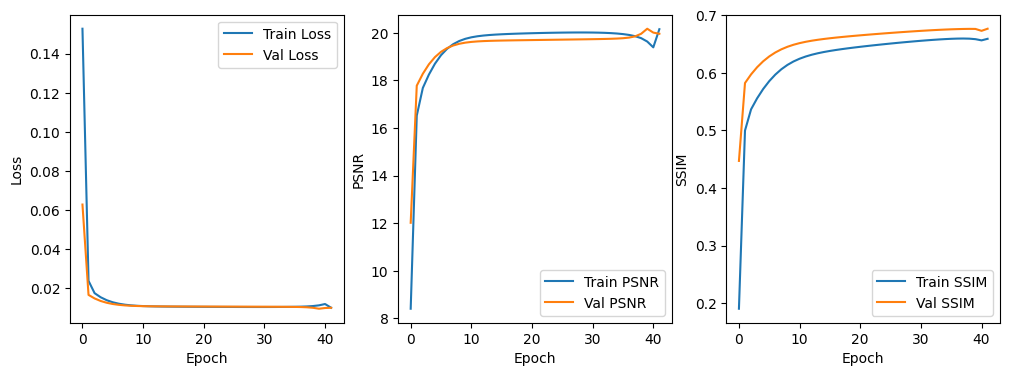

time: 293 ms (started: 2025-01-30 01:50:41 +07:00)


In [15]:
history = model.history

plt.figure(figsize=(12, 4))
    
# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
# Plot PSNR
plt.subplot(1, 3, 2)
plt.plot(history['train_metric']['psnr'], label='Train PSNR')
plt.plot(history['val_metric']['psnr'], label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

# Plot SSIM
plt.subplot(1, 3, 3)
plt.plot(history['train_metric']['ssim'], label='Train SSIM')
plt.plot(history['val_metric']['ssim'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.022452443257719785..1.0150621631284011].


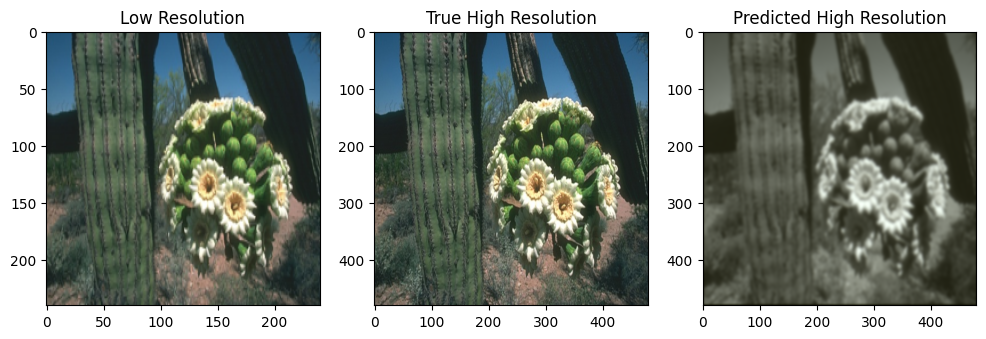

time: 2.09 s (started: 2025-01-30 15:20:29 +07:00)


In [17]:
test = X_test[1]
test = np.expand_dims(test, axis=0)

true = y_test[1]

pred = model.forward(test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test[0].transpose(1, 2, 0))
plt.title('Low Resolution')

plt.subplot(1, 3, 2)
plt.imshow(true.transpose(1, 2, 0))
plt.title('True High Resolution')

plt.subplot(1, 3, 3)
plt.imshow(pred[0].transpose(1, 2, 0))
plt.title('Predicted High Resolution')

plt.show()

In [18]:
model.load_model_weights('srcnn_model_100epochs_SGD.npz')
print(model.layers[-1].optimizer.learning_rate)

Model weights and parameters loaded from srcnn_model_100epochs_SGD.npz.npz
0.0125
time: 2.52 ms (started: 2025-01-30 15:20:34 +07:00)


In [ ]:
model.train(X_train, y_train, epochs=57, batch_size=4, validation=(X_val, y_val), continue_training=True)

Epoch 1/57: 100%|██████████| 18/18 [05:02<00:00, 16.82s/step, loss=0.00966, psnr=20.4, ssim=0.661]


Epoch 1 - train_loss: 0.0097 - train_psnr: 20.3554 - train_ssim: 0.6610
Epoch 1 - val_loss: 0.0099 - val_psnr: 20.0637 - val_ssim: 0.6774


Epoch 2/57: 100%|██████████| 18/18 [04:41<00:00, 15.62s/step, loss=0.00963, psnr=20.4, ssim=0.662]


Epoch 2 - train_loss: 0.0096 - train_psnr: 20.3678 - train_ssim: 0.6617
Epoch 2 - val_loss: 0.0098 - val_psnr: 20.0778 - val_ssim: 0.6777


Epoch 3/57: 100%|██████████| 18/18 [04:29<00:00, 14.98s/step, loss=0.0096, psnr=20.4, ssim=0.662] 


Epoch 3 - train_loss: 0.0096 - train_psnr: 20.3806 - train_ssim: 0.6621
Epoch 3 - val_loss: 0.0098 - val_psnr: 20.0928 - val_ssim: 0.6780


Epoch 4/57: 100%|██████████| 18/18 [04:58<00:00, 16.61s/step, loss=0.00957, psnr=20.4, ssim=0.662]


Epoch 4 - train_loss: 0.0096 - train_psnr: 20.3939 - train_ssim: 0.6625
Epoch 4 - val_loss: 0.0098 - val_psnr: 20.1086 - val_ssim: 0.6784


Epoch 5/57: 100%|██████████| 18/18 [04:32<00:00, 15.15s/step, loss=0.00954, psnr=20.4, ssim=0.663]


Epoch 5 - train_loss: 0.0095 - train_psnr: 20.4080 - train_ssim: 0.6629
Epoch 5 - val_loss: 0.0097 - val_psnr: 20.1253 - val_ssim: 0.6787


Epoch 6/57: 100%|██████████| 18/18 [04:32<00:00, 15.16s/step, loss=0.00951, psnr=20.4, ssim=0.663]


Epoch 6 - train_loss: 0.0095 - train_psnr: 20.4227 - train_ssim: 0.6633
Epoch 6 - val_loss: 0.0097 - val_psnr: 20.1430 - val_ssim: 0.6790


Epoch 7/57: 100%|██████████| 18/18 [04:38<00:00, 15.45s/step, loss=0.00947, psnr=20.4, ssim=0.664]


Epoch 7 - train_loss: 0.0095 - train_psnr: 20.4383 - train_ssim: 0.6638
Epoch 7 - val_loss: 0.0096 - val_psnr: 20.1617 - val_ssim: 0.6794


Epoch 8/57: 100%|██████████| 18/18 [04:33<00:00, 15.21s/step, loss=0.00943, psnr=20.5, ssim=0.664]


Epoch 8 - train_loss: 0.0094 - train_psnr: 20.4547 - train_ssim: 0.6642
Epoch 8 - val_loss: 0.0096 - val_psnr: 20.1815 - val_ssim: 0.6797


Epoch 9/57:  78%|███████▊  | 14/18 [03:37<01:02, 15.72s/step, loss=0.00961, psnr=20.4, ssim=0.66] 

In [46]:
model.save_model_weights('srcnn_model_100epochs_Adam')

Model weights and parameters saved to srcnn_model_100epochs_Adam.npz
time: 49.2 ms (started: 2025-01-28 04:26:15 +07:00)


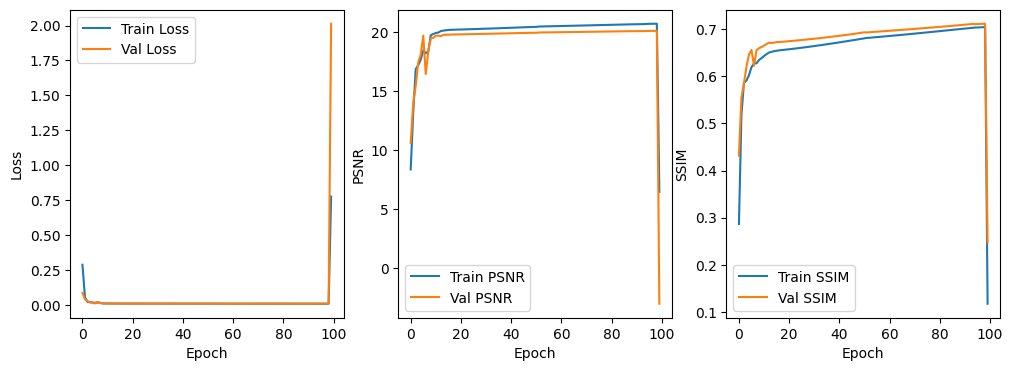

time: 1.41 s (started: 2025-01-28 23:38:52 +07:00)


In [15]:
history = model.history

plt.figure(figsize=(12, 4))
    
# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
# Plot PSNR
plt.subplot(1, 3, 2)
plt.plot(history['train_metric']['psnr'], label='Train PSNR')
plt.plot(history['val_metric']['psnr'], label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

# Plot SSIM
plt.subplot(1, 3, 3)
plt.plot(history['train_metric']['ssim'], label='Train SSIM')
plt.plot(history['val_metric']['ssim'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01680881221468055..1.044692534323806].


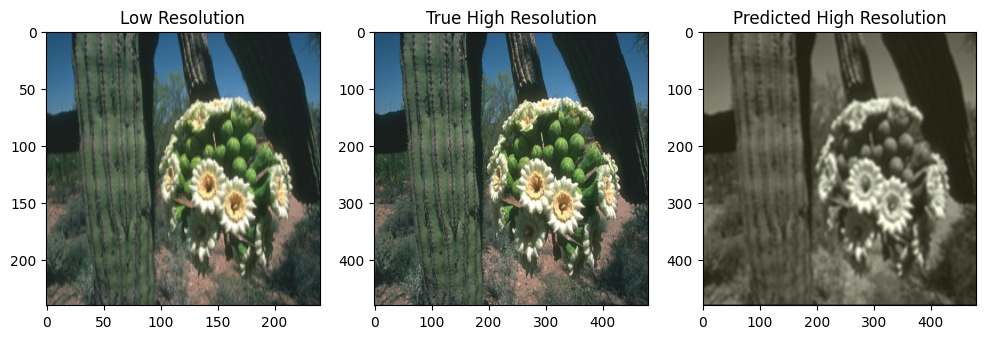

time: 1.55 s (started: 2025-01-28 10:31:04 +07:00)


In [48]:
test = X_test[1]
test = np.expand_dims(test, axis=0)

true = y_test[1]

pred = model.forward(test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test[0].transpose(1, 2, 0))
plt.title('Low Resolution')

plt.subplot(1, 3, 2)
plt.imshow(true.transpose(1, 2, 0))
plt.title('True High Resolution')

plt.subplot(1, 3, 3)
plt.imshow(pred[0].transpose(1, 2, 0))
plt.title('Predicted High Resolution')

plt.show()

In [27]:
model.evaluate(X_test, y_test)

(np.float64(0.008337259152062446),
 {'psnr': np.float64(20.78976698855434),
  'ssim': np.float64(0.6790541036771918)})

time: 33.9 s (started: 2025-01-29 02:02:50 +07:00)
